In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib widget


# Explication du fonctionnement des détections par courant de Foucault. 

Les systèmes de détections de courants de Foucault mesurent la variation des  réponses électromagnétique d'un objet à une excitation électromagnétique. Pour ce faire, deux bobines sont utilisées et excitées par un courant alternatif. 

Les bobines sont essentiellemnts des circuits RL dont la réponse en tension est donnée par:
$$
V_L(s) = \frac{Ls}{R + Ls} V_{in}(s)
$$
![](images/Series-RL.png)
https://en.wikipedia.org/wiki/RL_circuit

Une variation de l'inductance $L$ ou de la résistance $R$ de la bobine modifie la réponse en fréquence selon les équations suivantes:
![](images/gain_phase.png)


La première bobine sert de référence
alors que la seconde sera utilisée pour faire le *sensing* de l'objet. Les bobines sont déposés contre la surface de l'objet à détecter et le circuit est balancé pour que les deux bobines aient le même courant. En déplaçant les bobines sur la surface, les variations du champs induits créent des variations de l'inductance et de la résistance de la bobine de *sensing*. Pour mesurer ces variations, un pont de Wheatstone est utilisé.


![](images/1-s2.0-S0924424713004615-gr2.jpg)

Hongbo Wang, Zhihua Feng,
Ultrastable and highly sensitive eddy current displacement sensor using self-temperature compensation,
Sensors and Actuators A: Physical,
Volume 203,
2013,
Pages 362-368,
ISSN 0924-4247,
https://doi.org/10.1016/j.sna.2013.09.016.

Un exemple typique de signal mesuré (sans bruit ) est présenté ci-dessous. Une variation de la phase et de l'amplitude du signal est observée.

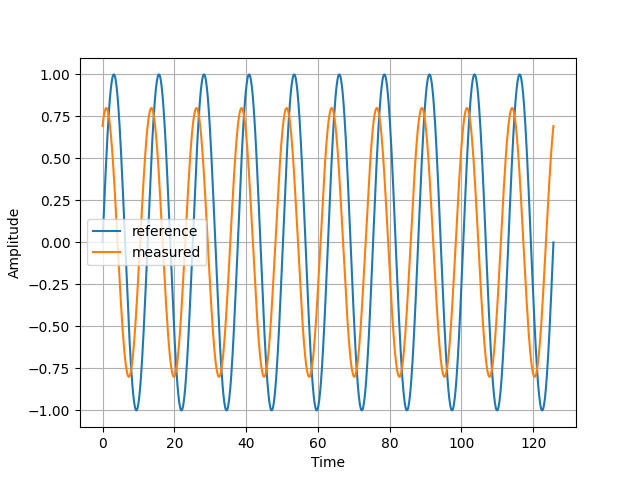

In [3]:
t = np.linspace(0, 40*np.pi, 1000)

amplitude = 0.8
phase = np.pi/3
freq = 0.5
x = np.sin(freq * t)
y_ref = amplitude*np.sin(freq * t + phase)
fig, ax = plt.subplots()    
ax.plot(t, x, label='reference')
ax.plot(t, y_ref, label='measured')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.grid(True)
ax.legend()

Les tensions mesurées passent alors dans le circuit suivant:

![](images/full_circuit.jpg)

Idem

L'amplificateur différentiel soustrait les deux tensions. Le résultat est alors distribué dans deux circuits de détections synchrones déphasés de 90 degrés.

Un circuit de détection synchrone permet d'extraire la composante en phase avec le signal de référence. Pour faire ceci, les deux signaux sont mixés puis intégrés sur une période largement supérieure à la période du signal.

La figure suivante montre le signal sortant de l'amplificateur différentiel ainsi que les deux signaux de référence déphasés. 

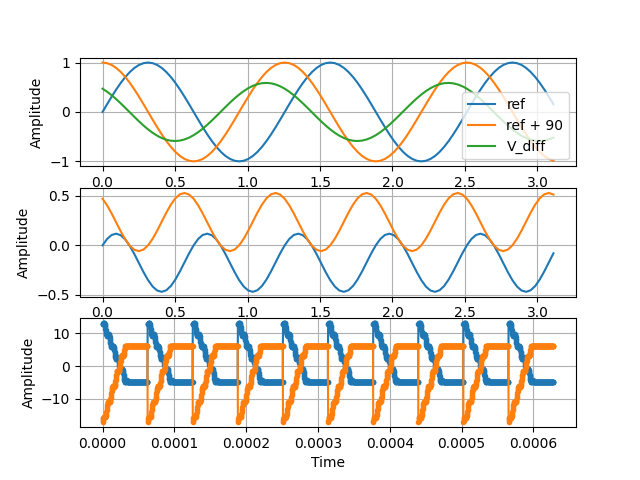

In [16]:
t = np.linspace(0, 2000*np.pi*1e-6, 20000)

amplitude = 0.8
phase = np.pi/5
freq = 0.5*1e6
x = np.sin(freq * t)
x_90 = np.sin(freq * t + np.pi/2)
y = amplitude*np.sin(freq * t + phase)
diff = y - x
fig, ax = plt.subplots(3, 1)    
ax[0].plot(t[:100], x[:100], label='ref')
ax[0].plot(t[:100], x_90[:100], label = 'ref + 90')
ax[0].plot(t[:100], diff[:100], label='V_diff')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)
ax[0].legend()

lock_in1 = diff * x
lock_in2 = diff * x_90
ax[1].plot(t[:100], lock_in1[:100], label='V_diff * ref')
ax[1].plot(t[:100], lock_in2[:100], label='V_diff * ref + 90')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
ax[1].grid(True)


def integral(signal, period):
    integral = np.zeros(len(signal))
    for i in range(1, len(signal)):
        if i % period == 0:
            signal[:i] = 0
        integral[i] = np.sum(signal[:i])
    integral = np.minimum(integral, np.max(integral)/2) #saturation
    integral = np.maximum(integral, np.min(integral)/2) #saturation
    integral = integral - np.mean(integral)
    return integral 

ax[2].plot(t[:len(t)//10], integral(lock_in1, 200)[:len(t)//10], label='integral(V_diff * ref)', marker='.')
ax[2].plot(t[:len(t)//10], integral(lock_in2, 200)[:len(t)//10], label='integral(V_diff * ref + 90)', marker='.')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Amplitude')
ax[2].grid(True)

Index(['% Time (s)', ' Channel A (Input 1) (V)', ' Channel B (Input 2) (V)'], dtype='object')


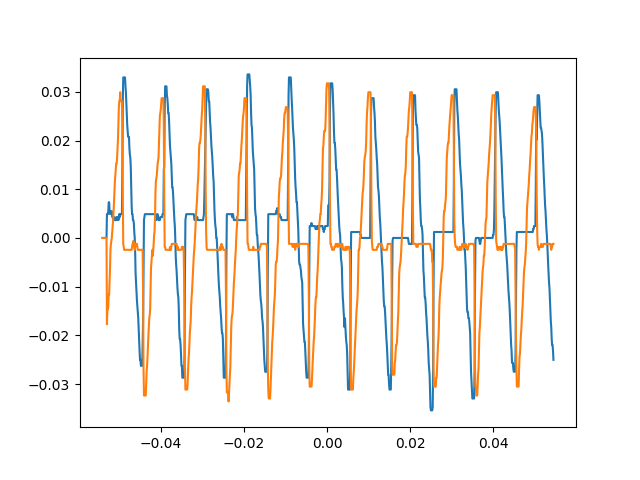

In [5]:
measures = 'measures2/channel_A_B_parallele_20230928_121640_Traces.csv'
# header is every line with % except the last one
first_measure = pd.read_csv(measures, header=8)
fig, ax = plt.subplots()
print(first_measure.columns)
def median_filter(signal, window_size):
    filtered = np.zeros(len(signal))
    for i in range(window_size, len(signal)):
        filtered[i] = np.median(signal[i-window_size:i])
    return filtered

ax.plot(first_measure[first_measure.columns[0]], median_filter(first_measure[first_measure.columns[1]], 10))
ax.plot(first_measure[first_measure.columns[0]], median_filter(first_measure[first_measure.columns[2]], 10))